In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.cuda.amp import autocast, GradScaler
import timm
from tqdm import tqdm
import pandas as pd
import os

In [ ]:
# 2. Daten laden
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Konstanten für optimale A100 Nutzung
BATCH_SIZE = 256  # Erhöhen wenn mehr GPU-Auslastung
NUM_EPOCHS = 20
NUM_CLASSES = 12 # Klassen im Klassifizierungsproblem (hier 12 angegebene Klassen)
TRAIN_SPLIT = 0.8
LEARNING_RATE = 2e-4  # Leicht erhöhen wenn größere Batches
NUM_WORKERS = 8  # Erhöhen für bessere Parallelisierung, Anzahl der Parallel-Threads für das Laden der Daten
PIN_MEMORY = True # Aktiviert die Nutzung von “pinned” Speicher, der schneller zwischen CPU und GPU übertragen werden kann (optimiert die Datentransfers für CUDA)
PREFETCH_FACTOR = 4 # Anzahl der Datenbatches, die der DataLoader vorab lädt

# Optimierungen für CUDA
torch.backends.cudnn.benchmark = True # Aktiviert den CUDNN-Benchmark-Modus (NVIDIA-Bibliothek, die für neuronale Netze optimiert ist = PyTorch testet verschiedene Algorithmen und wählt den schnellsten für die aktuelle Hardware und Konfiguration aus)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Automatische Gerätezuteilung, wenn cuda nicht verfügbar läuft auf CPU (dann aber achtung, evtl sind dann die Einstellungen so, dass memory voll läuft)

In [ ]:
# Datentransformationen
# Zwei Transformationen: können auf die Bilder angewendet werden, bereiten auf CNN vor

# train transform auf die Trainingsdaten
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Ändert die Größe des Bildes auf 224x224 Pixel, da ResNet diese Bildgröße erfordert
    transforms.RandomHorizontalFlip(), # Führt eine zufällige horizontale Spiegelung (Flipping) durch, damit die Variation der Trainingsdaten & somit das Training besser wird
    transforms.RandomRotation(15),  # Rotiert das Bild um einen zufälligen Winkel zwischen minus und plus 15 grad
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Verändert die Helligkeit, den Kontrast, die Sättigung und den Farbton des Bildes zufällig, damit wieder Variation mehr und Training besser: brightness um bis zu plus/minus30% etc
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Kombiniert mehrere Transformationen (z. B. Drehung, Skalierung, Translation), wendet auf bilder an: rotiert das Bild zufällig zwischen -/+10°, verschiebt das Bild zufällig bis zu 10 % der Bildbreite und -höhe, akaliert das Bild zufällig zwischen 90 % - 110 % der ursprünglichen Größe
    transforms.ToTensor(), # Konvertiert das Bild von einem PIL-Bild (oder NumPy-Array) in einen PyTorch-Tensor + es werden die Pixelwerte von [0, 255] auf den Bereich [0, 1] skaliert
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalisiert Pixelwerte des Bildes basierend auf den angegebenen mean und std: Durchschnittswerte für die RGB-Kanäle (basierend auf den Werten des ImageNet-Datensatzes) + Standardabweichungen für die RGB-Kanäle = hilft, die Konvergenz des Modells zu beschleunigen und Stabilität zu gewährleisten
])

# val transform auf die Test Daten
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Passt die Größe des Bildes an (wie bei den Trainingsdaten)
    transforms.ToTensor(), # Konvertiert das Bild in Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalisiert die Bilder, genauso wie bei den Trainingsdaten
])

In [ ]:
class CAPTCHAModel(nn.Module): # unsere captcha model Klasse erbt von nn.Module, der Basisklasse für alle neuronalen Netze in PyTorch, dadurch können wir alle PyTorch-Funktionen und -Methoden nutzen
    def __init__(self, num_classes):
        super(CAPTCHAModel, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True) # efficientnet_b0: vortrainiertes Modell aus der timm-Bibliothek, das für Bildklassifizierungsaufgaben optimiert ist

        # Das vortrainierte EfficientNet hat eine Standardklassifikationsschicht, die auf ImageNet (1000 Klassen) abgestimmt ist, diese muss ersetzt werden, um auf unsere spezifische Aufgabe der CAPTCHA-Klassifizierung zu passen
        self.model.classifier = nn.Sequential( # erlaubt, mehrere Schichten hintereinander zu stapeln
            nn.Dropout(0.3),  # Regularisierungstrick, bei dem während des Trainings zufällig 30 % der Neuronen “deaktiviert” werden, verhindert Overfitting: bietet eine gute Balance: 30%, weil: genug Regularisierung, um Overfitting zu reduzieren, aber nicht so viel, dass die Modellkapazität stark eingeschränkt wird (empirische Best Practice)
            nn.Linear(self.model.classifier.in_features, num_classes) # in_features = Eingabegröße (Anzahl der Neuronen) der ursprünglichen Klassifikationsschicht (wird automatisch gelesen) und num_classes = unsere Kategorien, 12
        )

    def forward(self, x): # forward-Methode definiert, wie die Eingabe durch das Modell verarbeitet wird
        return self.model(x) # x ist Eingabe, zb Bild

def load_data(train_val_dir):
    full_dataset = ImageFolder(train_val_dir, transform=train_transforms) # torchvision.datasets.ImageFolder, um Bilder aus einem Verzeichnis zu laden

    train_size = int(TRAIN_SPLIT * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    val_dataset.dataset.transform = val_transforms

    train_loader = DataLoader( # effizientes auf GPU spez. Laden der Daten in Batches
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True, # Mischt Daten bei jedem Durchlauf
        num_workers=NUM_WORKERS, # Anzahl der parallelen Worker-Prozesse zum Laden der Daten
        pin_memory=PIN_MEMORY, # Optimiert den Speicherzugriff für schnellere Datenübertragung von CPU zur GPU, oben definiert als True
        prefetch_factor=PREFETCH_FACTOR, # Lädt Daten im Voraus, um GPU-Leerlauf zu vermeiden, oben definiert als 4
        persistent_workers=True # Beibehaltung der Worker-Prozesse zwischen Epochen, um Latenzen zu reduzieren
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        prefetch_factor=PREFETCH_FACTOR,
        persistent_workers=True
    )

    return train_loader, val_loader, full_dataset.classes

def train_epoch(model, train_loader, criterion, optimizer, scaler):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in tqdm(train_loader, desc='Training'): # inputs: Bilder pro Batch,labels: unsere 12 Zielklassen, tqdm: Zeigt einen Fortschrittsbalken an
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) # Überträgt die Eingabedaten (inputs) und Labels (labels) auf die GPU oder CPU

        optimizer.zero_grad() # Setzt die Gradienten aller Modellparameter auf 0 zurück, notwendig, da PyTorch Gradienten während des Backpropagation akkumuliert

        with autocast():  # Mixed Precision Training: einige Berechnungen werden mit halber Präzision (FP16) ausgeführt, um Speicherverbrauch zu reduzieren und Training zu beschleunigen
            outputs = model(inputs)
            loss = criterion(outputs, labels) # Berechnung Fehler mit Verlustfunk (criterion)

        scaler.scale(loss).backward() # Berechnet die Gradienten des Verlusts in Bezug auf die Modellparameter (Gewichte und Biases)
        scaler.step(optimizer) # Aktualisiert die Modellparameter (z. B. Gewichte) basierend auf den Gradienten und der gewählten Optimierungsstrategie
        scaler.update()

        # Genauigkeit berechnen
        train_loss += loss.item()
        _, predicted = outputs.max(1) # Gibt die Klasse mit der höchsten Wahrscheinlichkeit (Vorhersage) für jede Eingabe zurück
        train_total += labels.size(0)
        train_correct += predicted.eq(labels).sum().item() # Vergleicht die vorhergesagten Klassen (predicted) mit den tatsächlichen Labels (labels), zählt die Anzahl der korrekten Vorhersagen und fügt diese zur Summe der korrekten Vorhersagen (train_correct) hinzu

    return train_loss / len(train_loader), 100. * train_correct / train_total

def validate(model, val_loader, criterion):
    model.eval() # Setzt das Modell in den Evaluierungsmodus (zb wird Dropout und Batch Normalisierung wird deaktiviert, weil kein Dropout in Val und festgelegte Mittelwerte und Standardabweichungen, die während des Trainings gelernt wurden werden für Val genommen)
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad(): # Deaktiviert die Gradientenberechnung während der Validierung
        for inputs, labels in tqdm(val_loader, desc='Validation'):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    return val_loss / len(val_loader), 100. * val_correct / val_total

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, model_save_dir, classes):
    scaler = GradScaler()
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler)
        val_loss, val_acc = validate(model, val_loader, criterion)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = os.path.join(model_save_dir, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'train_acc': train_acc,
                'classes': classes
            }, model_path)
            print(f'Saved best model with validation accuracy: {val_acc:.2f}%')

        # Cache leeren
        if torch.cuda.is_available():
            torch.cuda.empty_cache()


In [ ]:
def main():
    train_val_dir = '/content/drive/MyDrive/ML1/train_val_data'
    model_save_dir = '/content/drive/MyDrive/ML1/Best_Model'

    os.makedirs(model_save_dir, exist_ok=True)

    train_loader, val_loader, classes = load_data(train_val_dir)

    # Modell initialisieren
    model = CAPTCHAModel(NUM_CLASSES).to(DEVICE)

    # Loss und Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

    # Training starten
    train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, model_save_dir, classes)


In [ ]:
if __name__ == '__main__':
    main()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-5-8709b7621428>:92: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



Epoch 1/20


Training:   0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-5-8709b7621428>:55: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed Precision Training
Validation:   0%|          | 0/3 [00:00<?, ?it/s]<ipython-input-5-8709b7621428>:80: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]


Train Loss: 2.1968, Train Acc: 32.08%
Val Loss: 1.8597, Val Acc: 54.00%
Saved best model with validation accuracy: 54.00%

Epoch 2/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]


Train Loss: 1.4560, Train Acc: 66.29%
Val Loss: 1.2333, Val Acc: 64.83%
Saved best model with validation accuracy: 64.83%

Epoch 3/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Train Loss: 0.9468, Train Acc: 77.58%
Val Loss: 0.9750, Val Acc: 69.50%
Saved best model with validation accuracy: 69.50%

Epoch 4/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]


Train Loss: 0.5945, Train Acc: 85.17%
Val Loss: 0.7754, Val Acc: 76.17%
Saved best model with validation accuracy: 76.17%

Epoch 5/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.74it/s]


Train Loss: 0.3563, Train Acc: 91.54%
Val Loss: 0.6912, Val Acc: 79.67%
Saved best model with validation accuracy: 79.67%

Epoch 6/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Train Loss: 0.2142, Train Acc: 95.71%
Val Loss: 0.6534, Val Acc: 80.67%
Saved best model with validation accuracy: 80.67%

Epoch 7/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]


Train Loss: 0.1356, Train Acc: 97.79%
Val Loss: 0.6422, Val Acc: 81.00%
Saved best model with validation accuracy: 81.00%

Epoch 8/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Train Loss: 0.0839, Train Acc: 98.62%
Val Loss: 0.6642, Val Acc: 81.17%
Saved best model with validation accuracy: 81.17%

Epoch 9/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


Train Loss: 0.0577, Train Acc: 99.00%
Val Loss: 0.6727, Val Acc: 81.33%
Saved best model with validation accuracy: 81.33%

Epoch 10/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Train Loss: 0.0428, Train Acc: 99.46%
Val Loss: 0.6829, Val Acc: 81.33%

Epoch 11/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]


Train Loss: 0.0355, Train Acc: 99.67%
Val Loss: 0.6857, Val Acc: 81.50%
Saved best model with validation accuracy: 81.50%

Epoch 12/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.92it/s]


Train Loss: 0.0277, Train Acc: 99.96%
Val Loss: 0.6866, Val Acc: 81.50%

Epoch 13/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]


Train Loss: 0.0212, Train Acc: 99.92%
Val Loss: 0.6825, Val Acc: 81.33%

Epoch 14/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


Train Loss: 0.0172, Train Acc: 99.96%
Val Loss: 0.6820, Val Acc: 80.83%

Epoch 15/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Train Loss: 0.0141, Train Acc: 99.96%
Val Loss: 0.6833, Val Acc: 81.33%

Epoch 16/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Train Loss: 0.0121, Train Acc: 99.92%
Val Loss: 0.6790, Val Acc: 81.83%
Saved best model with validation accuracy: 81.83%

Epoch 17/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]


Train Loss: 0.0089, Train Acc: 100.00%
Val Loss: 0.7004, Val Acc: 81.83%

Epoch 18/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Train Loss: 0.0089, Train Acc: 99.96%
Val Loss: 0.6693, Val Acc: 82.33%
Saved best model with validation accuracy: 82.33%

Epoch 19/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]


Train Loss: 0.0058, Train Acc: 100.00%
Val Loss: 0.6800, Val Acc: 82.00%

Epoch 20/20


Validation: 100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Train Loss: 0.0048, Train Acc: 100.00%
Val Loss: 0.6853, Val Acc: 82.17%


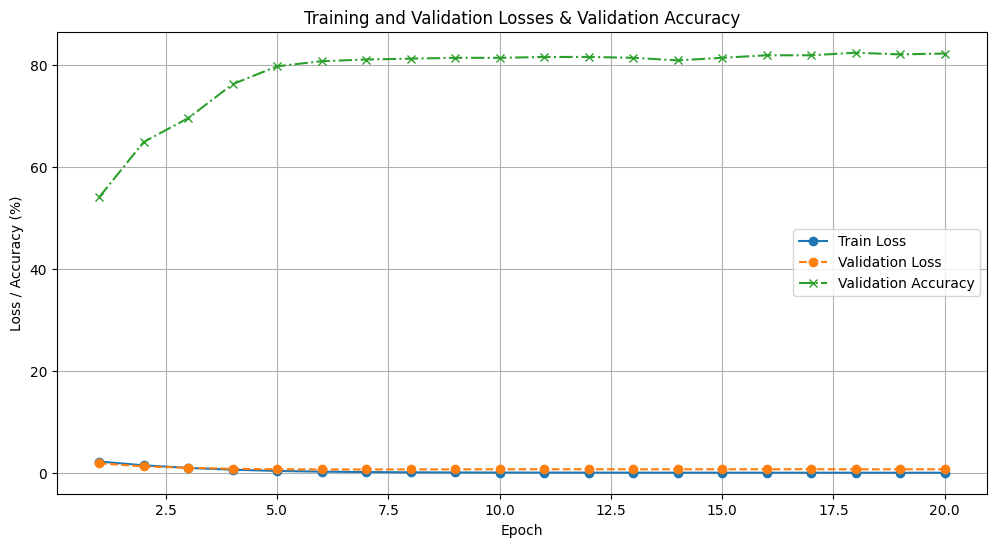

In [8]:
import matplotlib.pyplot as plt

# Daten aus dem Training
epochs = list(range(1, 21))
train_losses = [2.1968, 1.4560, 0.9468, 0.5945, 0.3563, 0.2142, 0.1356, 0.0839, 0.0577, 0.0428, 0.0355, 0.0277, 0.0212, 0.0172, 0.0141, 0.0121, 0.0089, 0.0089, 0.0058, 0.0048]
val_losses = [1.8597, 1.2333, 0.9750, 0.7754, 0.6912, 0.6534, 0.6422, 0.6642, 0.6727, 0.6829, 0.6857, 0.6866, 0.6825, 0.6820, 0.6833, 0.6790, 0.7004, 0.6693, 0.6800, 0.6853]
val_accuracies = [54.00, 64.83, 69.50, 76.17, 79.67, 80.67, 81.00, 81.17, 81.33, 81.33, 81.50, 81.50, 81.33, 80.83, 81.33, 81.83, 81.83, 82.33, 82.00, 82.17]

plt.figure(figsize=(12, 6))

plt.plot(epochs, train_losses, label="Train Loss", marker='o', linestyle='-')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o', linestyle='--')

plt.plot(epochs, val_accuracies, label="Validation Accuracy", marker='x', linestyle='-.')

plt.title("Training and Validation Losses & Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy (%)")
plt.legend()
plt.grid(True)

plt.show()

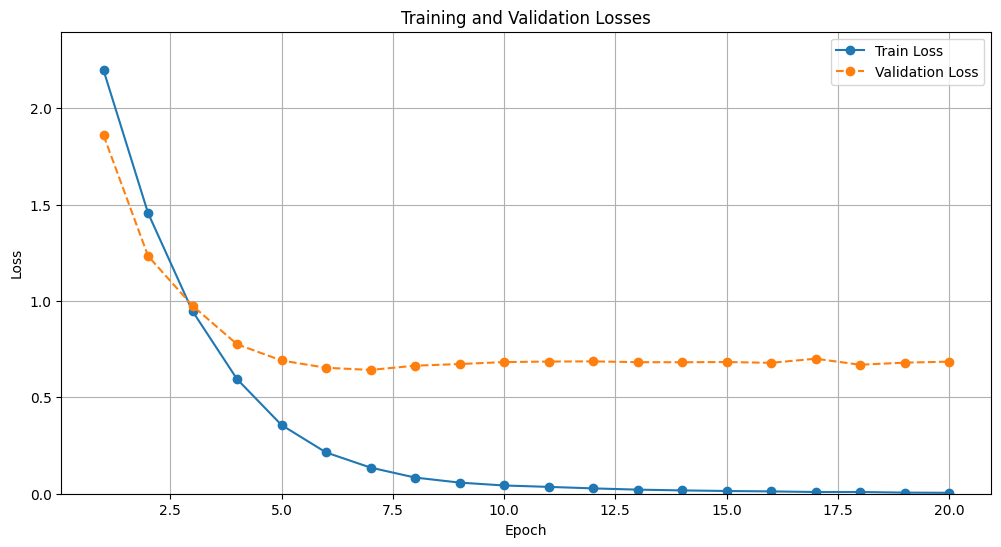

In [9]:
plt.figure(figsize=(12, 6))

plt.plot(epochs, train_losses, label="Train Loss", marker='o', linestyle='-')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o', linestyle='--')

plt.title("Training and Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(0, max(max(train_losses), max(val_losses)) + 0.2)  # Y-Achse anpassen, um Verluste besser sichtbar zu machen
plt.legend()
plt.grid(True)

plt.show()